In [1]:
%config Completer.use_jedi = False

import sys
sys.path.append('..')

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

use_cpu = False
cuda_device = '0'

if use_cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CPU_ONLY'] = "TRUE"
    physical_devices = tf.config.list_physical_devices('CPU')
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration() for i in range(8)])
    logical_devices = tf.config.list_logical_devices('CPU')

    print(logical_devices)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device
    os.environ['CPU_ONLY'] = "FALSE"
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import TNDM
from tndm.runtime import Runtime, ModelType
from tndm.utils import AdaptiveWeights
from tndm.models.model_loader import ModelLoader

from plotting import *

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# read the data
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

# test set is combined valid and test
neural_data = dataset['train_data'].astype('float')
valid_neural_data = dataset['valid_data'].astype('float')
test_neural_data = dataset['test_data'].astype('float')

behavioural_data = dataset['train_behaviours'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [3]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = 0.5

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(dropout=0.15, var_min=0.1, var_trainable=True))
layers_settings['relevant_decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    
layers_settings['irrelevant_decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))   
layers_settings['behavioural_dense'].update(dict(behaviour_type='causal'))    

initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005 

In [4]:
T = datetime.today().strftime("%y_%m_%d_%X")

logdir = os.path.join( spike_data_dir, 'log_l2_reg_'+str(l2_reg)+'_'+T)
modeldir = os.path.join( spike_data_dir, 'model_l2_reg_'+str(l2_reg)+'_'+T)

In [5]:
T0 = datetime.now()

model, history = Runtime.train(
    model_type=ModelType.TNDM,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        rel_factors=2,
        irr_factors=2,
        encoded_dim=64,
        max_grad_norm=200,
        encoded_var_trainable=True, ##changed
        encoded_var_min=0.1,
        timestep=settings['step'],
        seed=0
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 0, 0, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=0 # set to 2 to see the losses during training
)

model.save(modeldir)

print('Training took '+str(datetime.now()-T0))

/disk/scratch/mhennig/miniconda3/envs/latentneural-gpu/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Training took 0:30:47.796680


In [7]:
model = ModelLoader.load(modeldir, model_class=TNDM)

# Latent space

## Training data

In [8]:
log_f, b, (g0_r, mean_r, logvar_r), (g0_r, mean_i, logvar_i), (z_r, z_i) = \
    model(neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Irrelevant factors')

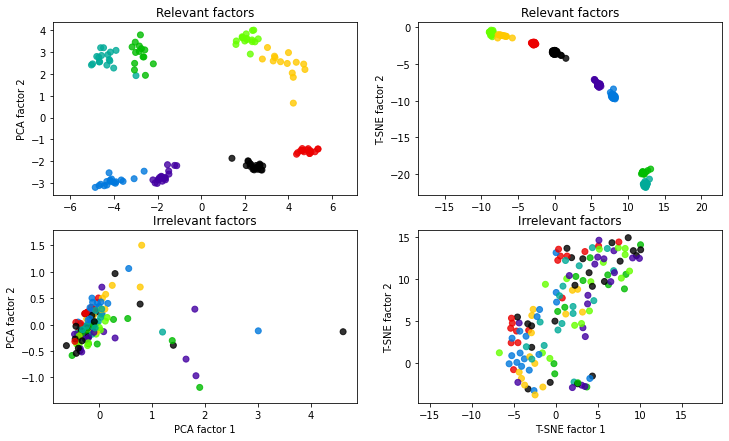

In [9]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2).fit_transform(mean_r)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Relevant factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean_r)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Relevant factors')

plt.subplot(223)
proj = PCA(n_components=2).fit_transform(mean_i)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Irrelevant factors')

plt.subplot(224)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean_i)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Irrelevant factors')

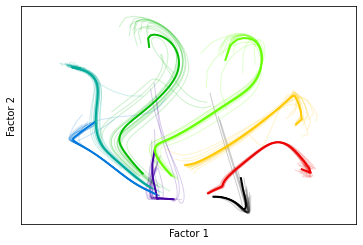

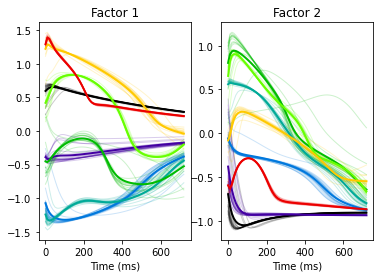

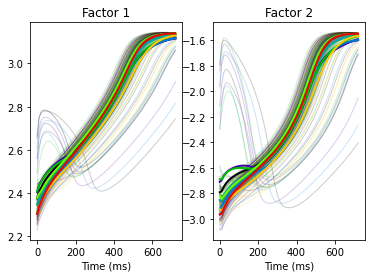

In [10]:
# latent factors

# relevant factors
plt.figure()
plot_all_2factors(z_r, direction_index_train)
# relevant factors
plt.figure()
plot_all_1factors(z_r, direction_index_train)
# irrelevant factors
plt.figure()
plot_all_1factors(z_i, direction_index_train)

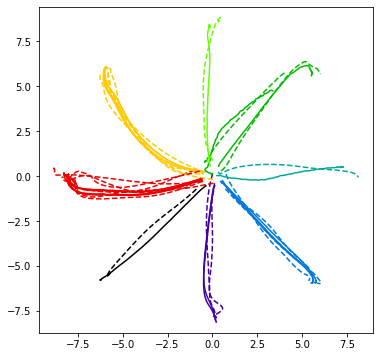

In [11]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train)

In [12]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 95.949%


## Test data

In [13]:
log_f_t, b_t, (g0_r_t, mean_r_t, logvar_r_t), (g0_r_t, mean_i_t, logvar_i_t), (z_r_t, z_i_t) = \
    model(test_neural_data.astype('float'), training=False)

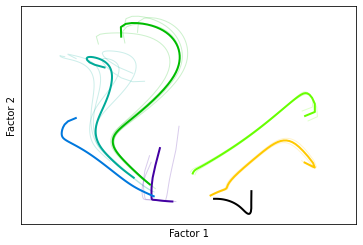

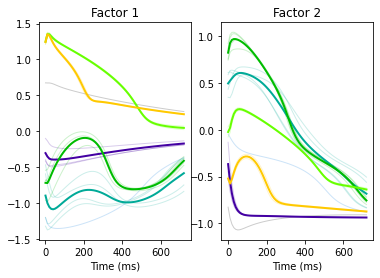

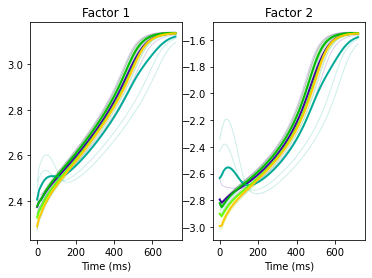

In [14]:
# relevant factors
plt.figure()
plot_all_2factors(z_r_t, direction_index_test)
# relevant factors
plt.figure()
plot_all_1factors(z_r_t, direction_index_test)
# irrelevant factors
plt.figure()
plot_all_1factors(z_i_t, direction_index_test)

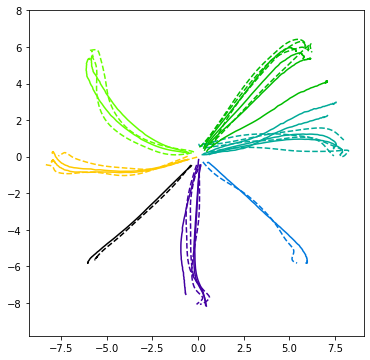

In [15]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test)

In [16]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 93.049%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

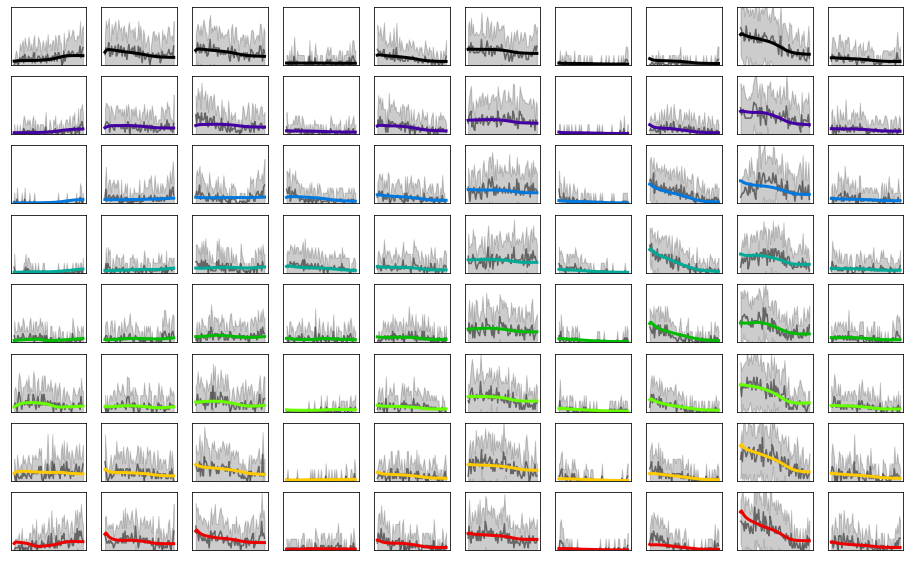

In [17]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,10)):
        ax = fig.add_subplot(8, 10, i*10+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

# Decoder weights

BehaviouralDense
2 2


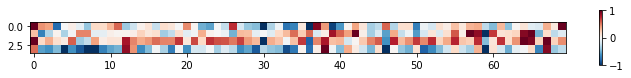

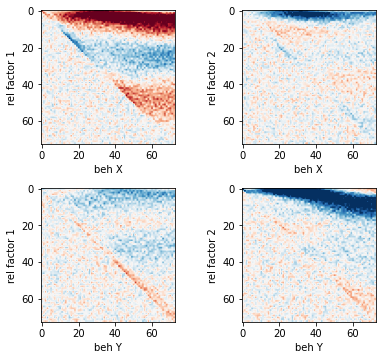

In [18]:
# neural decoder
plt.figure(figsize=(12,1))
plt.imshow((model.neural_dense._trainable_weights[0]),vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)
plt.colorbar()
# behaviour decoder
plot_behaviour_weights(model)